# 인물사진을 만들어보자

In [1]:
# 필요 모듈 import
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
# 이미지 불러오기
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images'
img_orig = cv2.imread(os.path.join(img_path, "me.jpg"))
img_orig2 = cv2.imread(os.path.join(img_path, "me2.jpg"))
img_cat = cv2.imread(os.path.join(img_path, "cat.jpg"))
img_chroma = cv2.imread(os.path.join(img_path, "chromakey.jpg"))
print (img_orig.shape)
print (img_orig2.shape)
print (img_cat.shape)
print (img_chroma.shape)

(2880, 2160, 3)
(4000, 6000, 3)
(4032, 3024, 3)
(4000, 6000, 3)


In [3]:
# DeepLabModel Class 정의
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# Model 다운로드
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/ssac10/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
# 이미지 resize
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max()) # cv2는 채널을 HWC 순서로 표시

# seg_map.max() 의 의미는 물체로 인식된 라벨 중 가장 큰 값을 뜻하며, label의 수와 일치

(2880, 2160, 3) (513, 384, 3) 15


In [6]:
# PASCAL VOC로 학습된 label
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

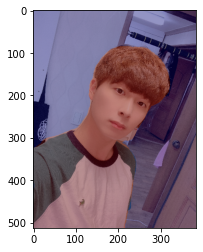

In [7]:
# 사람을 찾아 시각화
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출 person의 label은 15
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

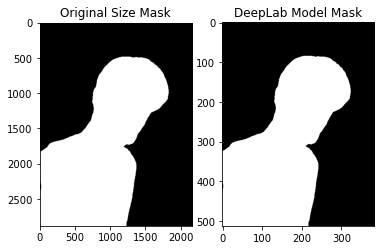

In [8]:
# 이미지 사이즈 비교
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

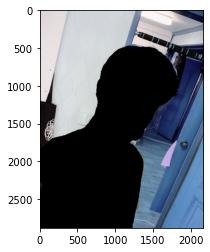

In [9]:
# 배경 이미지 얻기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

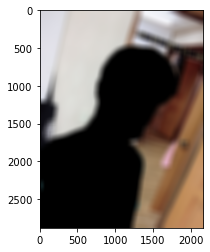

In [10]:
# 이미지 블러처리
img_bg_blur = cv2.blur(img_bg, (100,100))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

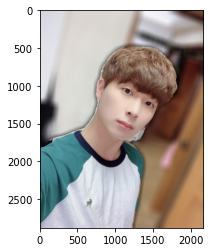

In [11]:
# 255인 부분만 원본을 가져온 후 나머지는 blur 이미지
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
# 이미지 저장
cv2.imwrite(os.path.join(img_path, "me_blur.jpg"), img_concat)

True

## 고양이 이미지

In [13]:
# 이미지 resize
img_resized, seg_map = MODEL.run(img_cat)
print (img_cat.shape, img_resized.shape, seg_map.max()) # cv2는 채널을 HWC 순서로 표시

# seg_map.max() 의 의미는 물체로 인식된 라벨 중 가장 큰 값을 뜻하며, label의 수와 일치

(4032, 3024, 3) (513, 384, 3) 8


In [14]:
# 8이므로 제대로 고양이로 인식
seg_map.max()

8

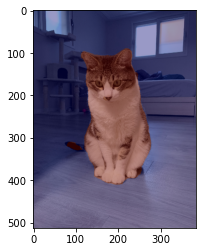

In [15]:
# 고양이를 찾아 시각화
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 사람만 추출 cat의 label은 8
img_mask_cat = seg_map * (255/seg_map.max()) # 255 normalization
img_mask_cat = img_mask_cat.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask_cat, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

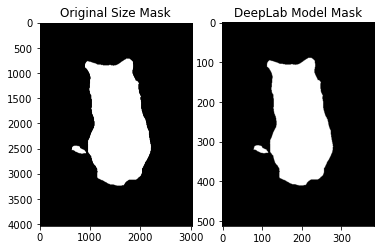

In [16]:
# 이미지 사이즈 비교
img_mask_up_cat = cv2.resize(img_mask_cat, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_cat = cv2.threshold(img_mask_up_cat, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_cat, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_cat, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

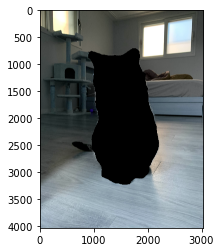

In [17]:
# 배경 이미지 얻기
img_mask_color_cat = cv2.cvtColor(img_mask_up_cat, cv2.COLOR_GRAY2BGR)
img_bg_mask_cat = cv2.bitwise_not(img_mask_color_cat)
img_bg_cat = cv2.bitwise_and(img_cat, img_bg_mask_cat)
plt.imshow(img_bg_cat)
plt.show()

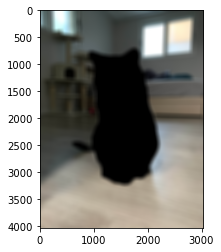

In [18]:
# 이미지 블러처리
img_bg_blur_cat = cv2.blur(img_bg_cat, (100,100))
plt.imshow(cv2.cvtColor(img_bg_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

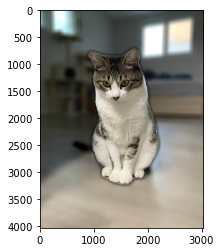

In [19]:
# 255인 부분만 원본을 가져온 후 나머지는 blur 이미지
img_concat_cat = np.where(img_mask_color_cat==255, img_cat, img_bg_blur_cat)
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
# 이미지 저장
cv2.imwrite(os.path.join(img_path, "cat_blur.jpg"), img_concat_cat)

True

## 크로마키 합성하기

In [21]:
# 이미지 resize
img_resized, seg_map = MODEL.run(img_orig2)
print (img_orig2.shape, img_resized.shape, seg_map.max()) # cv2는 채널을 HWC 순서로 표시

(4000, 6000, 3) (342, 513, 3) 16


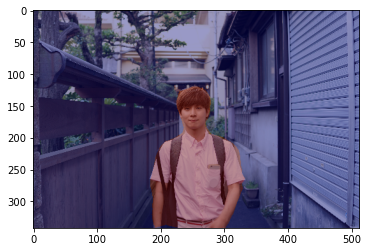

In [22]:
# 사람을 찾아 시각화
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출 person의 label은 15
img_mask2 = seg_map * (255/seg_map.max()) # 255 normalization
img_mask2 = img_mask2.astype(np.uint8)
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask2, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

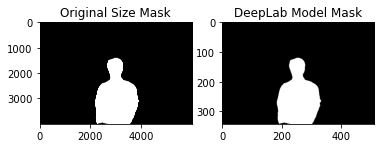

In [23]:
# 이미지 사이즈 비교
img_mask_up2 = cv2.resize(img_mask2, img_orig2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up2 = cv2.threshold(img_mask_up2, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up2, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask2, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

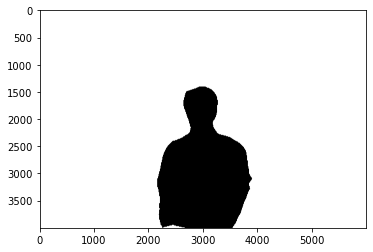

In [24]:
# 배경 이미지 얻기
img_mask_color2 = cv2.cvtColor(img_mask_up2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
plt.imshow(img_bg_mask2)
plt.show()

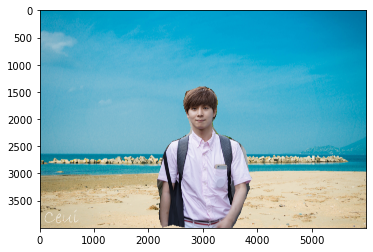

In [25]:
# 255인 부분만 원본을 가져온 후 나머지는 chromakey 이미지
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_chroma)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

In [26]:
# 이미지 저장
cv2.imwrite(os.path.join(img_path, "me2_chroma.jpg"), img_concat2)

True

## 이미지 비교

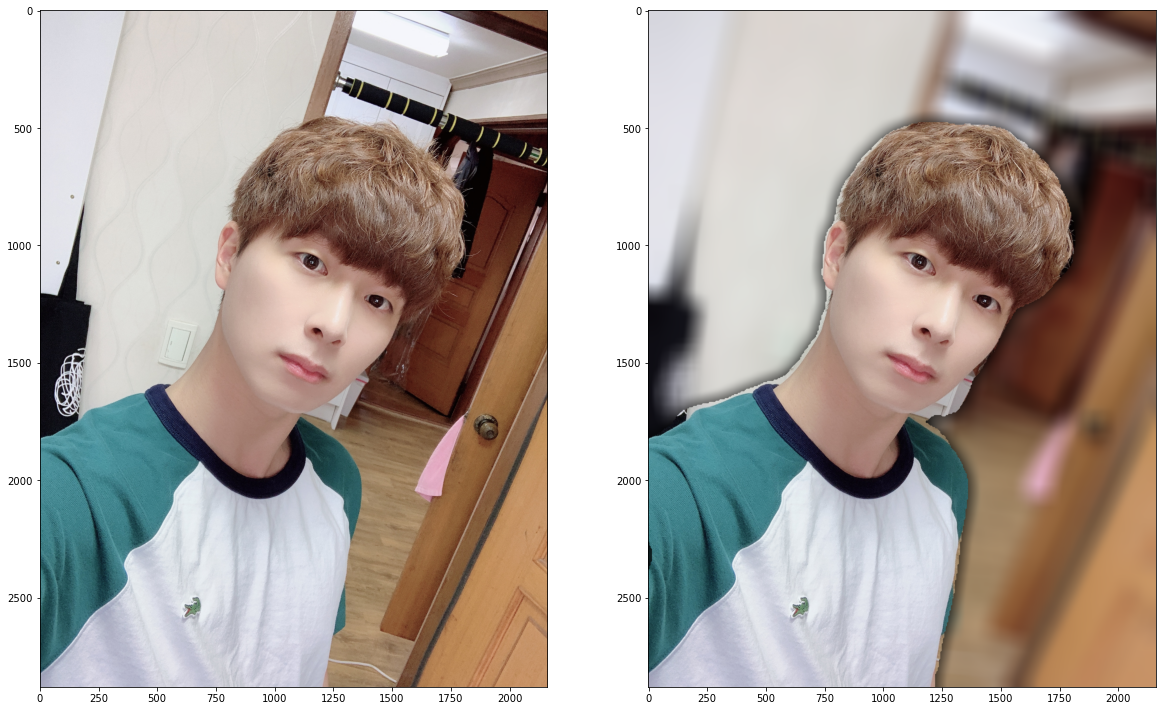

In [47]:
fig = plt.figure(figsize=(20, 15))

ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

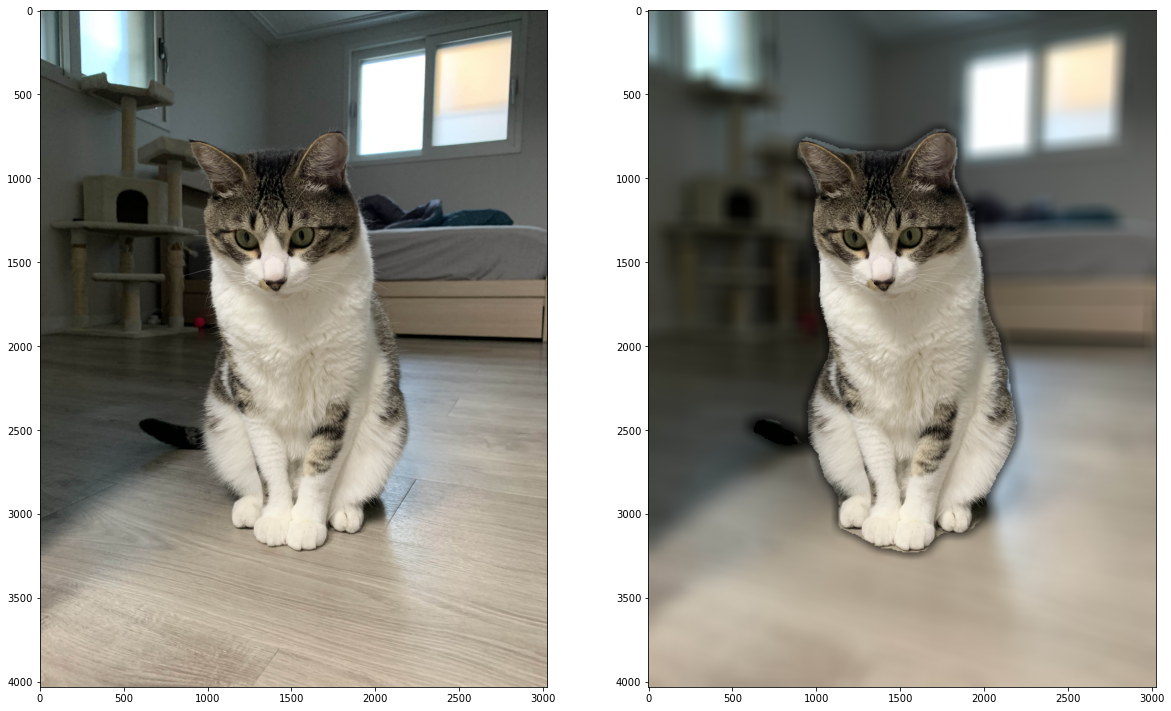

In [48]:
fig = plt.figure(figsize=(20, 15))

ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))

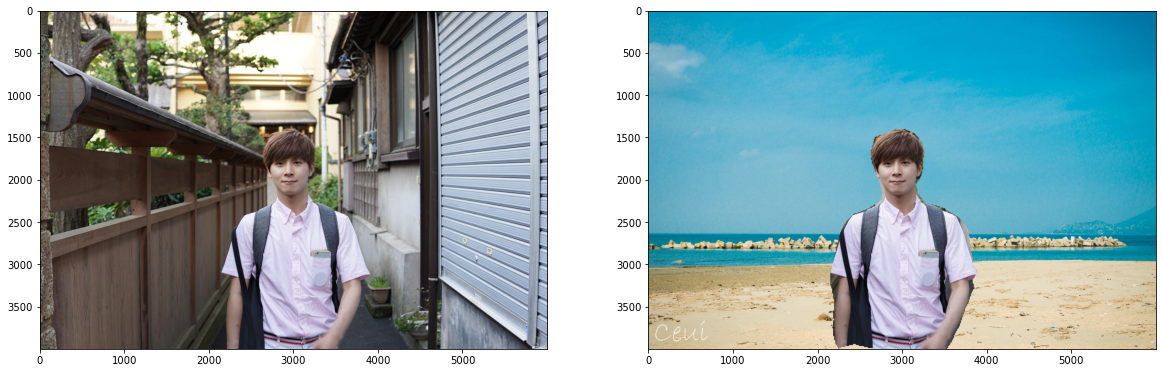

In [39]:
fig = plt.figure(figsize=(20, 15))

ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))

## 문제점

<div style="width:30%; height:30%;">
<img src="./images/me_blur_problem.png">
</div>

- 사진에서 보이는 것과 같이 얼굴 옆에 제대로 인식하지 못하여 블러처리가 덜 된 부분이 있었다. 이 부분은 인식률을 높이면 해결할 수 있을 것으로 예상된다.
- image mask를 블러처리 하는 과정에서 경계부분도 같이 블러처리가 되기 때문에, mask이미지 경계가 번져서 그림자가 진 것 처럼 보이게 되는 것이다. 이러한 현상이 발생하는 이유는 블러가 적용되는 원리에 의해 주변의 이미지까지 같이 어둡게 만들어버리기 때문이라고 생각한다.
- 마찬가지로 블러처리 된 부분과 그렇지 않은 부분의 경계가 너무 날카로워서 인물이 붕 떠있는 것 같은 부자연스러운 사진처럼 느껴진다.

## 문제 해결 방법

- 제대로 인식하지 못하는 부분은 사진의 사진의 심도 정보를 가지고 있으면 인식률을 더욱 높일 수 있을 것 같다. 예를 들어, 두 개의 카메라를 이용하면 사진의 각 부분별로 심도를 계산할 수 있을 것이고, 계산된 심도를 이용하여 object의 경계를 더 정확하게 구분할 수 있을 것이라고 생각한다.object를 구분하는 기준은 아마도 심도의 변화량이 큰 부분이 될 것이다. 심도의 변화량이 크다는 이야기는 심도가 급격하게 변한다는 이야기고, 심도가 급격하게 변하는 곳은 object와 object가 분리되는 지점일 것이다. 따라서 심도 정보를 가지고 있다면, object의 경계를 더 정확하게 구분할 수 있으므로, 인식률이 올라갈 것이다.
- 블러처리로 인해 발생하는 mask 경계 주변의 번짐현상은 블러를 적용할 때 mask된 부분은 제외하고 블러처리를 할 수 있도록 알고리즘을 수정하면 해결할 수 있을 것 같다.
- 경계가 날카로운 부분 같은 경우에는 블러처리를 하는 과정에서 이미지를 합친 후에도 경계를 기준으로 경계 안과 밖의 n pixel정도를 연속적인 블러를 적용해주면 더 자연스러워 질 것 같다. 연속적인 블러란, 경계를 기준으로 가까울 수록 강한 블러 효과를 적용하고, 멀어질 수록 약한 블러 효과를 적용하는 것을 말한다.

<div style="width:60%; height:60%;">
<img src="./images/human_segmentation.png">
</div>

## 회고록

- 평소에 사진을 취미로 하고 있어서 이번 과제를 이해하는 것이 어렵지 않았다.
- 이미지 세그멘테이션에 대해 단어만 알고 정확히 어떤 역할을 하는 기술인지 잘 몰랐는데 이번 학습을 통해 확실하게 알 수 있었다.
- 이미지를 블러처리 하는 과정에서 인물과 배경의 경계 부분도 같이 블러처리 되어버리기 때문에 나중에 이미지를 병합하는 과정에서 배경에 있는 인물 영역이 실제 사진의 인물 영역보다 넓어져 병합 후의 이미지에서 경계 주위로 그림자(?)가 지는 것 같은 현상을 볼 수 있었다.
- 앞으로 자율주행이나 인공지능을 이용해서 자동화 할 수 있는 부분에는 어디든 사용될 수 있을 법한 그런 기술인 것 같다.
- 이 기술을 이용해서 병, 캔, 플라스틱 과 같은 재활용 쓰레기를 구분할 수 있다고 하면, 환경 분야에서도 쓸 수 있지 않을까...? 그 정도로 구분하는 것은 어려울 것 같긴 하다.
- jupyter notebook에서 생성된 이미지를 깔끔하게 보이도록 정리하려고 html을 이용하여 사진을 정렬했었는데 github에선 html style이 무시된다는 것을 알게되어 3시간 정도를 이미지 정렬하는 데 썼다... 결국 안 된다는 것을 깨닫고 pyplot을 이용해서 비교하였다.